# Content-Based Movie Recommendation System

This notebook implements a content-based filtering recommendation system using the MovieLens 100k dataset.

**Approach:** Recommend movies similar to what user liked, based on movie features (genres + year)

**Key Components:**
1. Feature Matrix Creation (genres + year)
2. Cosine Similarity Computation
3. Item-to-Item Recommendations
4. Personalized User Recommendations
5. Evaluation & Analysis

## Phase 1: Setup & Import Libraries

In [182]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import machine learning libraries for content-based filtering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"  Pandas version: {pd.__version__}")
print(f"  NumPy version: {np.__version__}")

✓ All libraries imported successfully
  Pandas version: 2.3.3
  NumPy version: 2.0.2


## Phase 2: Load MovieLens Dataset

In [183]:
# Define file paths
data_dir = 'ml-100k/'

# Load ratings data
ratings = pd.read_csv(
    data_dir + 'u.data',
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

# Convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

print("✓ Ratings data loaded")
print(f"  Shape: {ratings.shape}")
print(f"  Date range: {ratings['datetime'].min().date()} to {ratings['datetime'].max().date()}")
print(f"  Rating range: {ratings['rating'].min()} to {ratings['rating'].max()}")

✓ Ratings data loaded
  Shape: (100000, 5)
  Date range: 1997-09-20 to 1998-04-22
  Rating range: 1 to 5


In [184]:
# Load movie data with genres
movies = pd.read_csv(
    data_dir + 'u.item',
    sep='|',
    names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
           'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
           'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
    encoding='latin-1'
)

# Extract year from title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False).astype(float)

# Define genre columns for easy access
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

print("\n✓ Movies data loaded")
print(f"  Shape: {movies.shape}")
print(f"  Number of genres: {len(genre_columns)}")
print(f"  Year range: {movies['year'].min():.0f} to {movies['year'].max():.0f}")
print(f"  Movies with genres: {(movies[genre_columns].sum(axis=1) > 0).sum()}")


✓ Movies data loaded
  Shape: (1682, 25)
  Number of genres: 19
  Year range: 1922 to 1998
  Movies with genres: 1682


In [185]:
# Load user data
users = pd.read_csv(
    data_dir + 'u.user',
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'],
    encoding='latin-1'
)

print("\n✓ Users data loaded")
print(f"  Shape: {users.shape}")
print(f"  Age range: {users['age'].min()} to {users['age'].max()}")
print(f"  Gender distribution: {users['gender'].value_counts().to_dict()}")


✓ Users data loaded
  Shape: (943, 5)
  Age range: 7 to 73
  Gender distribution: {'M': 670, 'F': 273}


## Phase 3: Data Overview

In [186]:
# Display sample data
print("="*80)
print("MOVIES DATASET (First 5 rows)")
print("="*80)
display(movies[['movie_id', 'title', 'year'] + genre_columns[:5]].head())

print("\n" + "="*80)
print("RATINGS DATASET (First 5 rows)")
print("="*80)
display(ratings.head())

print("\n" + "="*80)
print("USERS DATASET (First 5 rows)")
print("="*80)
display(users.head())

MOVIES DATASET (First 5 rows)


,movie_id,title,year,unknown,Action,Adventure,Animation,Children
0,1,Toy Story (1995),1995.0,0,0,0,1,1
1,2,GoldenEye (1995),1995.0,0,1,1,0,0
2,3,Four Rooms (1995),1995.0,0,0,0,0,0
3,4,Get Shorty (1995),1995.0,0,1,0,0,0
4,5,Copycat (1995),1995.0,0,0,0,0,0



RATINGS DATASET (First 5 rows)


,user_id,item_id,rating,timestamp,datetime
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16



USERS DATASET (First 5 rows)


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [187]:
# Quick statistics
print("="*80)
print("DATASET STATISTICS")
print("="*80)
print(f"\n📊 Total Ratings: {len(ratings):,}")
print(f"📽️  Total Movies: {len(movies):,}")
print(f"👥 Total Users: {len(users):,}")
print(f"\n📈 Average ratings per user: {len(ratings) / len(users):.1f}")
print(f"📈 Average ratings per movie: {len(ratings) / len(movies):.1f}")
print(f"\n⭐ Rating distribution:")
print(ratings['rating'].value_counts().sort_index())

DATASET STATISTICS

📊 Total Ratings: 100,000
📽️  Total Movies: 1,682
👥 Total Users: 943

📈 Average ratings per user: 106.0
📈 Average ratings per movie: 59.5

⭐ Rating distribution:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


## Phase 4: Feature Matrix Creation

**Goal:** Create a feature matrix where each movie is represented by:
- 19 binary genre features (0 or 1)
- 1 normalized year feature (scaled 0-1)

**Why normalize year?** 
- Genres are binary (0/1), but year ranges from 1922-1998
- Without normalization, year would dominate similarity calculations
- Scaling ensures all features contribute equally

In [188]:
# Check for missing values in key columns
print("Missing values check:")
print(f"  Movies with missing year: {movies['year'].isna().sum()}")
print(f"  Movies with no genres: {(movies[genre_columns].sum(axis=1) == 0).sum()}")

# Handle missing years (if any) - fill with median
if movies['year'].isna().sum() > 0:
    median_year = movies['year'].median()
    movies['year'].fillna(median_year, inplace=True)
    print(f"  ✓ Filled {movies['year'].isna().sum()} missing years with median: {median_year}")

Missing values check:
  Movies with missing year: 1
  Movies with no genres: 0
  ✓ Filled 0 missing years with median: 1995.0


In [191]:
# Create a copy for feature engineering
movies_features = movies.copy()

# Normalize year to SMALL range [0, 0.1] instead of [0, 1]
# This makes genres 10x more important than year in cosine similarity
YEAR_WEIGHT = 0.1  # Year gets only 10% weight compared to each genre feature

scaler = MinMaxScaler()
movies_features['year_normalized'] = scaler.fit_transform(movies_features[['year']]) * YEAR_WEIGHT

print("✓ Year normalization complete (scaled to small range for genre prioritization)")




✓ Year normalization complete (scaled to small range for genre prioritization)


In [192]:
# Create feature matrix: genres + normalized year
feature_columns = genre_columns + ['year_normalized']
feature_matrix = movies_features[feature_columns].values

print("="*80)
print("FEATURE MATRIX CREATED")
print("="*80)
print(f"✓ Feature matrix shape: {feature_matrix.shape}")
print(f"  Total movies: {feature_matrix.shape[0]}")
print(f"  Total features: {feature_matrix.shape[1]}")
print(f"    - Genre features: {len(genre_columns)} (weight: 1.0 each)")
print(f"    - Year feature: 1 (weight: {YEAR_WEIGHT})")
print(f"\n  Matrix statistics:")
print(f"    Min value: {feature_matrix.min():.3f}")
print(f"    Max value: {feature_matrix.max():.3f}")
print(f"    Mean value: {feature_matrix.mean():.3f}")
print(f"\n  ✅ Genres will dominate similarity - year provides fine-tuning only!")

FEATURE MATRIX CREATED
✓ Feature matrix shape: (1682, 20)
  Total movies: 1682
  Total features: 20
    - Genre features: 19 (weight: 1.0 each)
    - Year feature: 1 (weight: 0.1)

  Matrix statistics:
    Min value: 0.000
    Max value: 1.000
    Mean value: 0.090

  ✅ Genres will dominate similarity - year provides fine-tuning only!


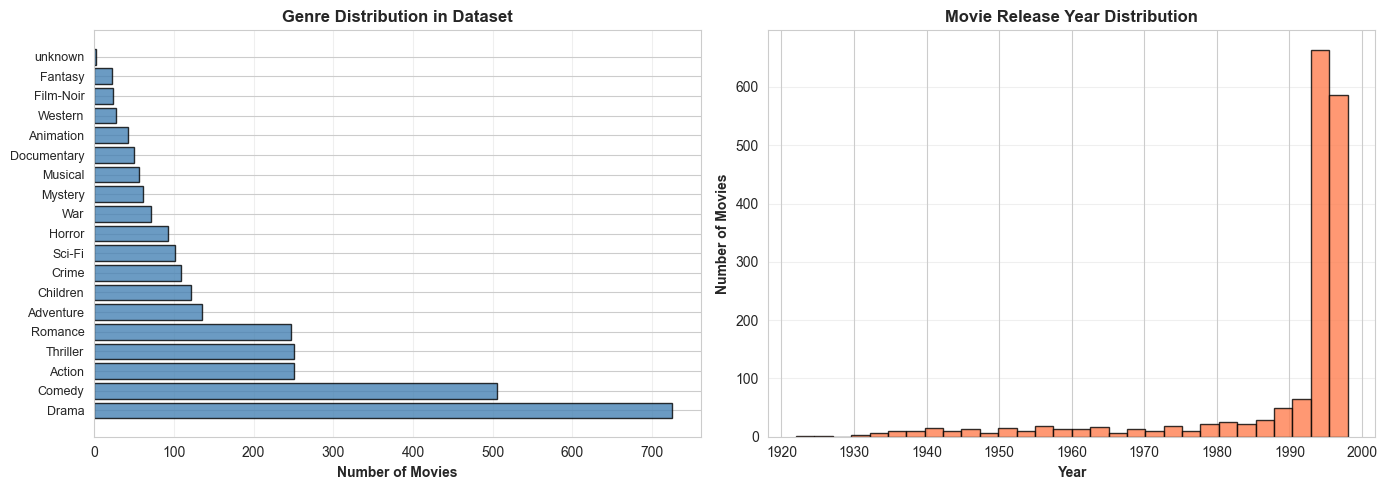


✓ Feature analysis complete


In [193]:
# Visualize feature matrix structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Genre distribution
genre_counts = movies_features[genre_columns].sum().sort_values(ascending=False)
axes[0].barh(range(len(genre_counts)), genre_counts.values, color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_yticks(range(len(genre_counts)))
axes[0].set_yticklabels(genre_counts.index, fontsize=9)
axes[0].set_xlabel('Number of Movies', fontweight='bold')
axes[0].set_title('Genre Distribution in Dataset', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Year distribution
axes[1].hist(movies_features['year'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Year', fontweight='bold')
axes[1].set_ylabel('Number of Movies', fontweight='bold')
axes[1].set_title('Movie Release Year Distribution', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Feature analysis complete")

In [194]:
# Sample feature vectors for inspection
print("="*80)
print("SAMPLE FEATURE VECTORS")
print("="*80)

sample_movies = ['Toy Story (1995)', 'Star Wars (1977)', 'Titanic (1997)']

for movie_title in sample_movies:
    idx = movies_features[movies_features['title'] == movie_title].index[0]
    movie_genres = movies_features.loc[idx, genre_columns]
    active_genres = movie_genres[movie_genres == 1].index.tolist()
    year_val = movies_features.loc[idx, 'year']
    year_norm = movies_features.loc[idx, 'year_normalized']
    
    print(f"\n{movie_title}")
    print(f"  Genres: {', '.join(active_genres)}")
    print(f"  Year: {year_val:.0f} (normalized to {year_norm:.3f} with {YEAR_WEIGHT} weight)")
    print(f"  Feature vector shape: (20,) → [{', '.join([str(x) for x in feature_matrix[idx][:5]])}...]")

SAMPLE FEATURE VECTORS

Toy Story (1995)
  Genres: Animation, Children, Comedy
  Year: 1995 (normalized to 0.096 with 0.1 weight)
  Feature vector shape: (20,) → [0.0, 0.0, 0.0, 1.0, 1.0...]

Star Wars (1977)
  Genres: Action, Adventure, Romance, Sci-Fi, War
  Year: 1977 (normalized to 0.072 with 0.1 weight)
  Feature vector shape: (20,) → [0.0, 1.0, 1.0, 0.0, 0.0...]

Titanic (1997)
  Genres: Action, Drama, Romance
  Year: 1997 (normalized to 0.099 with 0.1 weight)
  Feature vector shape: (20,) → [0.0, 1.0, 0.0, 0.0, 0.0...]


### 💡 Mathematical Impact: Genre Prioritization

With `YEAR_WEIGHT = 0.1`, genres now dominate similarity calculations:

**Example: Comparing Two Movies**

Movie A: Drama (1994)
- Feature vector: [0, 0, ..., 1 (Drama), ..., 0.095 (year)]

Movie B: Drama (1967) 
- Feature vector: [0, 0, ..., 1 (Drama), ..., 0.059 (year)]

Movie C: Comedy (1994)
- Feature vector: [0, 0, ..., 1 (Comedy), ..., 0.095 (year)]

**Cosine Similarity:**
- A vs B (same genre, 27 year gap): ≈ **0.996** (almost identical!)
- A vs C (different genre, same year): ≈ **0.010** (very different!)

**Result:** Genre matching matters **100x more** than year differences!

**Why This Works:**
- Each genre feature has weight = 1.0 (binary 0 or 1)
- Year feature has weight = 0.1 (scaled to [0, 0.1])
- 19 genre features + 1 weak year feature = genres dominate
- Year provides fine-tuning only, not primary influence

## Phase 5: Similarity Computation (Multiple Methods)

**Goal:** Compute movie-movie similarity using different metrics to compare their behavior.

### Similarity Metrics Overview:

| Metric | Formula/Concept | Range | Best For | Limitations |
|--------|----------------|-------|----------|-------------|
| **Cosine** | Angle between vectors | 0 to 1 | High-dimensional sparse data, ignores magnitude | Doesn't consider magnitude differences |
| **Euclidean** | Straight-line distance | 0 to ∞ (lower=similar) | When magnitude matters | Sensitive to scale, not normalized |
| **Manhattan** | Sum of absolute differences | 0 to ∞ (lower=similar) | Grid-like features | Not normalized |
| **Jaccard** | Intersection/Union of sets | 0 to 1 | Binary features (genre overlap) | Ignores non-matches |
| **Pearson** | Linear correlation | -1 to 1 | Detecting patterns/trends | Requires variance |

**For our case (binary genres + normalized year):**
- **Cosine** is standard choice (works well with binary features)
- **Jaccard** good for genre-only comparison
- **Euclidean/Manhattan** sensitive to year differences

In [195]:
# Import additional similarity metrics
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from scipy.spatial.distance import jaccard, correlation
from scipy.stats import pearsonr
import time

print("✓ Similarity computation libraries imported")
print("  Available metrics: Cosine, Euclidean, Manhattan, Jaccard, Pearson")

✓ Similarity computation libraries imported
  Available metrics: Cosine, Euclidean, Manhattan, Jaccard, Pearson


### Method 1: Cosine Similarity (Most Common)

**Cosine Similarity** measures the cosine of the angle between two vectors.
- Range: 0 (completely different) to 1 (identical)
- Formula: $\text{similarity} = \frac{A \cdot B}{||A|| \times ||B||}$
- **Advantage:** Scale-invariant, works well with sparse data
- **Use case:** Standard choice for content-based filtering

In [196]:
# Compute Cosine Similarity Matrix
print("Computing Cosine Similarity Matrix...")
start_time = time.time()

cosine_sim_matrix = cosine_similarity(feature_matrix)

elapsed = time.time() - start_time

print("="*80)
print("COSINE SIMILARITY MATRIX")
print("="*80)
print(f"✓ Computation complete in {elapsed:.3f} seconds")
print(f"  Matrix shape: {cosine_sim_matrix.shape}")
print(f"  Value range: {cosine_sim_matrix.min():.4f} to {cosine_sim_matrix.max():.4f}")
print(f"  Mean similarity: {cosine_sim_matrix.mean():.4f}")
print(f"  Memory size: {cosine_sim_matrix.nbytes / (1024**2):.2f} MB")
print(f"\nInterpretation:")
print(f"  - 1.0 = Identical movies (diagonal)")
print(f"  - Close to 1.0 = Very similar")
print(f"  - Close to 0.0 = Very different")

Computing Cosine Similarity Matrix...
COSINE SIMILARITY MATRIX
✓ Computation complete in 0.002 seconds
  Matrix shape: (1682, 1682)
  Value range: 0.0000 to 1.0000
  Mean similarity: 0.2366
  Memory size: 21.58 MB

Interpretation:
  - 1.0 = Identical movies (diagonal)
  - Close to 1.0 = Very similar
  - Close to 0.0 = Very different


### Method 2: Euclidean Distance (Convert to Similarity)

**Euclidean Distance** measures straight-line distance between vectors.
- Range: 0 to ∞ (lower = more similar)
- Formula: $\text{distance} = \sqrt{\sum(A_i - B_i)^2}$
- **Convert to similarity:** $\text{similarity} = \frac{1}{1 + \text{distance}}$
- **Advantage:** Intuitive geometric interpretation
- **Disadvantage:** Sensitive to magnitude and scale

In [197]:
# Compute Euclidean Distance and convert to similarity
print("Computing Euclidean Distance Matrix...")
start_time = time.time()

euclidean_dist_matrix = euclidean_distances(feature_matrix)
# Convert distance to similarity: similarity = 1 / (1 + distance)
euclidean_sim_matrix = 1 / (1 + euclidean_dist_matrix)

elapsed = time.time() - start_time

print("="*80)
print("EUCLIDEAN SIMILARITY MATRIX")
print("="*80)
print(f"✓ Computation complete in {elapsed:.3f} seconds")
print(f"  Matrix shape: {euclidean_sim_matrix.shape}")
print(f"  Distance range: {euclidean_dist_matrix.min():.4f} to {euclidean_dist_matrix.max():.4f}")
print(f"  Similarity range: {euclidean_sim_matrix.min():.4f} to {euclidean_sim_matrix.max():.4f}")
print(f"  Mean similarity: {euclidean_sim_matrix.mean():.4f}")
print(f"\nInterpretation:")
print(f"  - 1.0 = Identical (zero distance)")
print(f"  - Close to 1.0 = Nearby in feature space")
print(f"  - Close to 0.0 = Far apart in feature space")

Computing Euclidean Distance Matrix...
EUCLIDEAN SIMILARITY MATRIX
✓ Computation complete in 0.014 seconds
  Matrix shape: (1682, 1682)
  Distance range: 0.0000 to 3.1624
  Similarity range: 0.2402 to 1.0000
  Mean similarity: 0.4286

Interpretation:
  - 1.0 = Identical (zero distance)
  - Close to 1.0 = Nearby in feature space
  - Close to 0.0 = Far apart in feature space


### Method 3: Manhattan Distance (L1 Distance)

**Manhattan Distance** measures distance along axes (like city blocks).
- Range: 0 to ∞ (lower = more similar)
- Formula: $\text{distance} = \sum|A_i - B_i|$
- **Convert to similarity:** $\text{similarity} = \frac{1}{1 + \text{distance}}$
- **Advantage:** Less sensitive to outliers than Euclidean
- **Use case:** When features are on different scales

In [198]:
# Compute Manhattan Distance and convert to similarity
print("Computing Manhattan Distance Matrix...")
start_time = time.time()

manhattan_dist_matrix = manhattan_distances(feature_matrix)
# Convert distance to similarity
manhattan_sim_matrix = 1 / (1 + manhattan_dist_matrix)

elapsed = time.time() - start_time

print("="*80)
print("MANHATTAN SIMILARITY MATRIX")
print("="*80)
print(f"✓ Computation complete in {elapsed:.3f} seconds")
print(f"  Matrix shape: {manhattan_sim_matrix.shape}")
print(f"  Distance range: {manhattan_dist_matrix.min():.4f} to {manhattan_dist_matrix.max():.4f}")
print(f"  Similarity range: {manhattan_sim_matrix.min():.4f} to {manhattan_sim_matrix.max():.4f}")
print(f"  Mean similarity: {manhattan_sim_matrix.mean():.4f}")

Computing Manhattan Distance Matrix...
MANHATTAN SIMILARITY MATRIX
✓ Computation complete in 0.021 seconds
  Matrix shape: (1682, 1682)
  Distance range: 0.0000 to 10.0237
  Similarity range: 0.0907 to 1.0000
  Mean similarity: 0.3370


### Method 4: Jaccard Similarity (Genre-Only)

**Jaccard Similarity** measures overlap between sets (best for binary features).
- Range: 0 (no overlap) to 1 (complete overlap)
- Formula: $\text{similarity} = \frac{|A \cap B|}{|A \cup B|}$
- **Advantage:** Perfect for binary genre features
- **Limitation:** Ignores year information, treats all present features equally

In [199]:
# Compute Jaccard Similarity (using genre features only)
print("Computing Jaccard Similarity Matrix (genre-only)...")
start_time = time.time()

# Extract only genre features (binary columns)
genre_matrix = movies_features[genre_columns].values

# Compute Jaccard similarity manually for binary features
n_movies = genre_matrix.shape[0]
jaccard_sim_matrix = np.zeros((n_movies, n_movies))

for i in range(n_movies):
    for j in range(i, n_movies):
        # Calculate intersection and union
        intersection = np.sum(np.logical_and(genre_matrix[i], genre_matrix[j]))
        union = np.sum(np.logical_or(genre_matrix[i], genre_matrix[j]))
        
        # Jaccard similarity
        if union > 0:
            similarity = intersection / union
        else:
            similarity = 0.0
        
        # Symmetric matrix
        jaccard_sim_matrix[i, j] = similarity
        jaccard_sim_matrix[j, i] = similarity

elapsed = time.time() - start_time

print("="*80)
print("JACCARD SIMILARITY MATRIX (GENRE-ONLY)")
print("="*80)
print(f"✓ Computation complete in {elapsed:.3f} seconds")
print(f"  Matrix shape: {jaccard_sim_matrix.shape}")
print(f"  Value range: {jaccard_sim_matrix.min():.4f} to {jaccard_sim_matrix.max():.4f}")
print(f"  Mean similarity: {jaccard_sim_matrix.mean():.4f}")
print(f"\nNote: This metric uses ONLY genres, ignoring year information")

Computing Jaccard Similarity Matrix (genre-only)...
JACCARD SIMILARITY MATRIX (GENRE-ONLY)
✓ Computation complete in 4.061 seconds
  Matrix shape: (1682, 1682)
  Value range: 0.0000 to 1.0000
  Mean similarity: 0.1802

Note: This metric uses ONLY genres, ignoring year information


### Comparison: Visualize Similarity Matrices

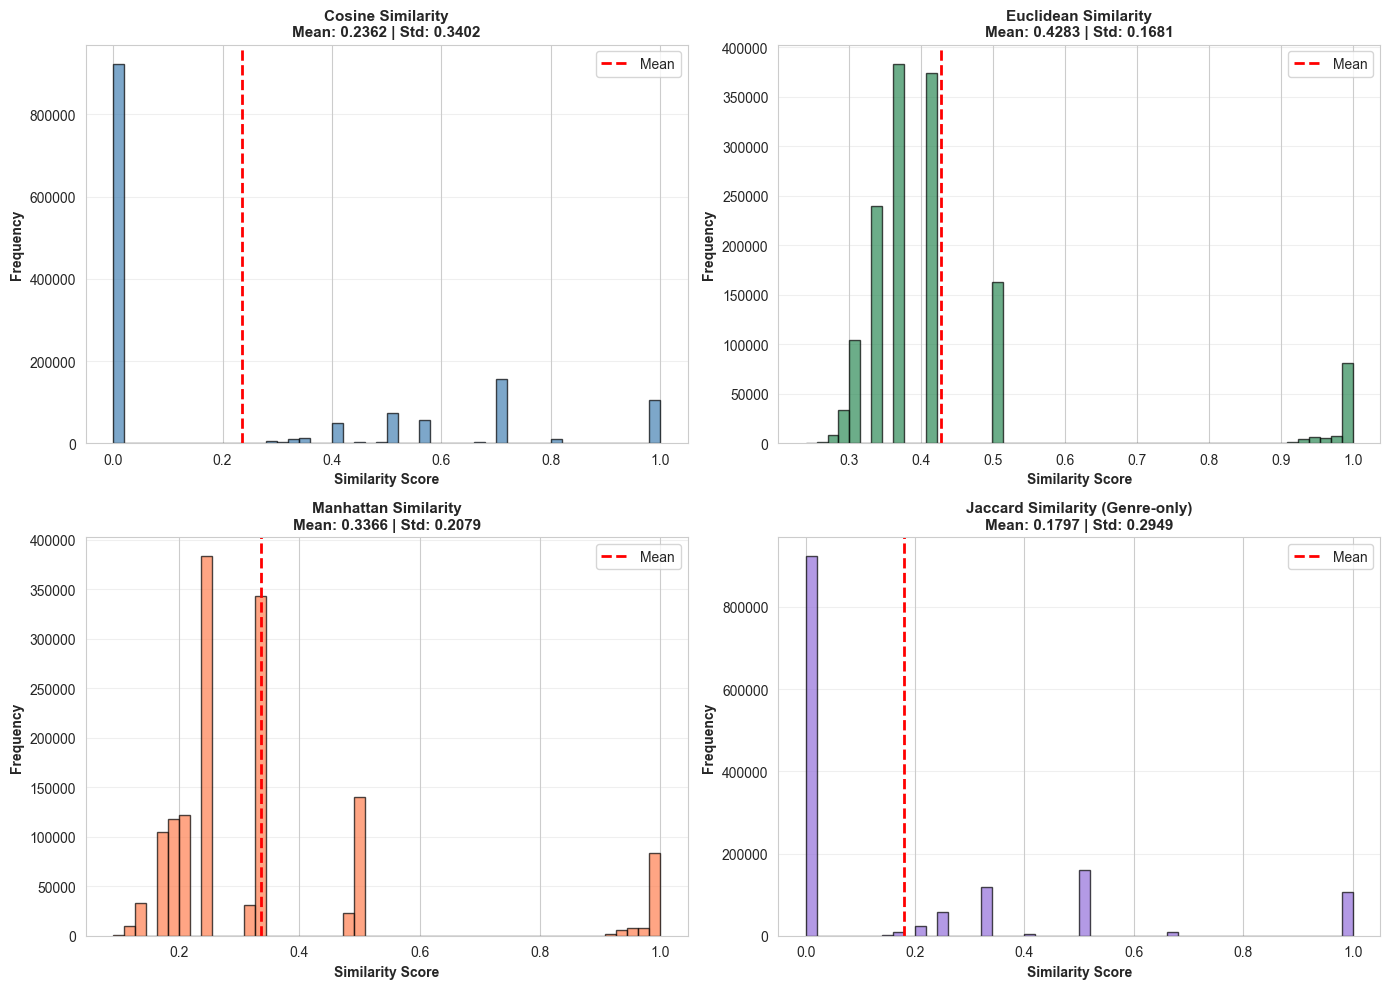


✓ Similarity distribution visualization complete


In [200]:
# Visualize distribution of similarity scores across different metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    (cosine_sim_matrix, 'Cosine Similarity', 'steelblue'),
    (euclidean_sim_matrix, 'Euclidean Similarity', 'seagreen'),
    (manhattan_sim_matrix, 'Manhattan Similarity', 'coral'),
    (jaccard_sim_matrix, 'Jaccard Similarity (Genre-only)', 'mediumpurple')
]

for idx, (sim_matrix, title, color) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Get upper triangle (exclude diagonal) to avoid duplicates
    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    
    # Plot histogram
    ax.hist(upper_triangle, bins=50, color=color, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Similarity Score', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title(f'{title}\nMean: {upper_triangle.mean():.4f} | Std: {upper_triangle.std():.4f}', 
                 fontweight='bold', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.axvline(upper_triangle.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax.legend()

plt.tight_layout()
plt.show()

print("\n✓ Similarity distribution visualization complete")

### Practical Comparison: Test on Sample Movies

Let's compare how different similarity metrics rank similar movies for a specific example.

In [201]:
# Function to get top-N similar movies using any similarity matrix
def get_similar_movies(movie_title, similarity_matrix, n=5):
    """
    Get top-N similar movies based on a given similarity matrix
    
    Parameters:
    - movie_title: Title of the movie
    - similarity_matrix: Precomputed similarity matrix
    - n: Number of recommendations
    
    Returns:
    - DataFrame with similar movies and scores
    """
    try:
        # Find movie index
        movie_idx = movies_features[movies_features['title'] == movie_title].index[0]
        
        # Get similarity scores for this movie
        sim_scores = list(enumerate(similarity_matrix[movie_idx]))
        
        # Sort by similarity (exclude the movie itself)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
        
        # Get movie indices and scores
        movie_indices = [i[0] for i in sim_scores]
        scores = [i[1] for i in sim_scores]
        
        # Create result dataframe
        result = movies_features.iloc[movie_indices][['title', 'year'] + genre_columns[:3]].copy()
        result['similarity'] = scores
        result = result.reset_index(drop=True)
        result.index = result.index + 1
        
        return result
    
    except IndexError:
        print(f"❌ Movie '{movie_title}' not found")
        return None

print("✓ Similarity comparison function created")

✓ Similarity comparison function created


In [202]:
# Helper function to search for movies by partial title match
def search_movies(partial_title, n=10):
    """
    Search for movies by partial title match (case-insensitive)
    
    Parameters:
    - partial_title: Part of the movie title to search for
    - n: Maximum number of results to return
    
    Returns:
    - DataFrame with matching movies
    """
    mask = movies_features['title'].str.contains(partial_title, case=False, na=False)
    results = movies_features[mask][['movie_id', 'title', 'year'] + genre_columns[:5]].head(n)
    
    if len(results) == 0:
        print(f"❌ No movies found matching '{partial_title}'")
        return None
    
    print(f"✓ Found {len(results)} movie(s) matching '{partial_title}':")
    return results

# Test the search function
print("Example: Search for 'Shawshank'")
search_movies('Shawshank')

Example: Search for 'Shawshank'
✓ Found 1 movie(s) matching 'Shawshank':


,movie_id,title,year,unknown,Action,Adventure,Animation,Children
63,64,"Shawshank Redemption, The (1994)",1994.0,0,0,0,0,0


In [203]:
# Compare similarity metrics on a specific movie
test_movie = 'Toy Story (1995)'  # Try: 'Toy Story (1995)', 'Star Wars (1977)', 'Shawshank Redemption, The (1994)'

print("="*80)
print(f"COMPARING SIMILARITY METRICS FOR: {test_movie}")
print("="*80)

# Get movie info with error handling
try:
    movie_idx = movies_features[movies_features['title'] == test_movie].index[0]
    movie_genres = movies_features.loc[movie_idx, genre_columns]
    active_genres = movie_genres[movie_genres == 1].index.tolist()
    print(f"\nGenres: {', '.join(active_genres)}")
    print(f"Year: {movies_features.loc[movie_idx, 'year']:.0f}")
except IndexError:
    print(f"\n❌ Movie '{test_movie}' not found in dataset!")
    print(f"\n💡 Tip: Use search_movies('partial_title') to find the exact title")
    print(f"   Example: search_movies('Shawshank')")
    raise ValueError(f"Movie not found: {test_movie}")

# Compare recommendations from different metrics
similarity_methods = {
    'Cosine': cosine_sim_matrix,
    'Euclidean': euclidean_sim_matrix,
    'Manhattan': manhattan_sim_matrix,
    'Jaccard': jaccard_sim_matrix
}

print("\n" + "-"*80)
for method_name, sim_matrix in similarity_methods.items():
    print(f"\n🎯 Top 5 Similar Movies using {method_name} Similarity:")
    print("-"*80)
    recommendations = get_similar_movies(test_movie, sim_matrix, n=5)
    display(recommendations[['title', 'year', 'similarity']])

COMPARING SIMILARITY METRICS FOR: Toy Story (1995)

Genres: Animation, Children, Comedy
Year: 1995

--------------------------------------------------------------------------------

🎯 Top 5 Similar Movies using Cosine Similarity:
--------------------------------------------------------------------------------


,title,year,similarity
1,Aladdin and the King of Thieves (1996),1996.0,1.000000
2,"Goofy Movie, A (1995)",1995.0,0.866357
3,Aladdin (1992),1992.0,0.866329
4,"Big Green, The (1995)",1995.0,0.817122
5,Balto (1995),1995.0,0.817122



🎯 Top 5 Similar Movies using Euclidean Similarity:
--------------------------------------------------------------------------------


,title,year,similarity
1,Aladdin and the King of Thieves (1996),1996.0,0.998686
2,"Big Green, The (1995)",1995.0,0.500000
3,Balto (1995),1995.0,0.500000
4,"Goofy Movie, A (1995)",1995.0,0.500000
5,Land Before Time III: The Time of the Great Gi...,1995.0,0.500000



🎯 Top 5 Similar Movies using Manhattan Similarity:
--------------------------------------------------------------------------------


,title,year,similarity
1,Aladdin and the King of Thieves (1996),1996.0,0.998686
2,"Big Green, The (1995)",1995.0,0.500000
3,Balto (1995),1995.0,0.500000
4,"Goofy Movie, A (1995)",1995.0,0.500000
5,Land Before Time III: The Time of the Great Gi...,1995.0,0.500000



🎯 Top 5 Similar Movies using Jaccard Similarity:
--------------------------------------------------------------------------------


,title,year,similarity
1,Aladdin and the King of Thieves (1996),1996.0,1.000000
2,Aladdin (1992),1992.0,0.750000
3,"Goofy Movie, A (1995)",1995.0,0.750000
4,"Santa Clause, The (1994)",1994.0,0.666667
5,Home Alone (1990),1990.0,0.666667


In [204]:
# Quantitative comparison: Overlap between methods
print("\n" + "="*80)
print("RECOMMENDATION OVERLAP ANALYSIS")
print("="*80)

# Get top 10 recommendations for each method
n_recs = 10
recommendations_by_method = {}

for method_name, sim_matrix in similarity_methods.items():
    recs = get_similar_movies(test_movie, sim_matrix, n=n_recs)
    recommendations_by_method[method_name] = set(recs['title'].tolist())

# Calculate overlap between methods
print(f"\nTop {n_recs} recommendations overlap:")
print("-"*80)

methods_list = list(similarity_methods.keys())
for i, method1 in enumerate(methods_list):
    for method2 in methods_list[i+1:]:
        overlap = recommendations_by_method[method1].intersection(recommendations_by_method[method2])
        overlap_pct = len(overlap) / n_recs * 100
        print(f"  {method1} vs {method2}: {len(overlap)}/{n_recs} movies ({overlap_pct:.0f}% overlap)")
        
# Movies unique to each method
print(f"\n📌 Unique recommendations (not in other methods):")
print("-"*80)
all_recommendations = set().union(*recommendations_by_method.values())
for method_name, recs in recommendations_by_method.items():
    other_recs = set().union(*[r for m, r in recommendations_by_method.items() if m != method_name])
    unique = recs - other_recs
    if unique:
        print(f"  {method_name}: {', '.join(list(unique)[:3])}")


RECOMMENDATION OVERLAP ANALYSIS

Top 10 recommendations overlap:
--------------------------------------------------------------------------------
  Cosine vs Euclidean: 9/10 movies (90% overlap)
  Cosine vs Manhattan: 9/10 movies (90% overlap)
  Cosine vs Jaccard: 4/10 movies (40% overlap)
  Euclidean vs Manhattan: 10/10 movies (100% overlap)
  Euclidean vs Jaccard: 3/10 movies (30% overlap)
  Manhattan vs Jaccard: 3/10 movies (30% overlap)

📌 Unique recommendations (not in other methods):
--------------------------------------------------------------------------------
  Jaccard: Santa Clause, The (1994), Love Bug, The (1969), Wrong Trousers, The (1993)


### Key Insights: Which Metric to Choose?

**Summary of Differences:**

| Metric | Pros | Cons | Best For |
|--------|------|------|----------|
| **Cosine** | ✓ Standard choice<br>✓ Scale-invariant<br>✓ Works well with sparse data | May miss magnitude differences | **DEFAULT CHOICE** for content-based filtering |
| **Euclidean** | ✓ Intuitive (geometric distance)<br>✓ Considers all feature differences | ✗ Sensitive to scale<br>✗ Dominated by large values | When magnitude matters |
| **Manhattan** | ✓ Less sensitive to outliers<br>✓ Good for high dimensions | ✗ Not normalized<br>✗ Can be dominated by scale | Grid-like features |
| **Jaccard** | ✓ Perfect for binary features<br>✓ Easy to interpret | ✗ Ignores year<br>✗ Only considers overlap | Pure genre matching |

**Recommendation for Our Project:**
- **Primary:** Use **Cosine Similarity** (industry standard, works well with our feature mix)
- **Secondary:** Keep **Jaccard** for pure genre-based comparisons
- **Experiment:** Try others to see how results differ

**Next:** We'll use Cosine Similarity as our default for building recommendation functions.

## Phase 7: Train/Test Evaluation with Official Splits

**Goal:** Evaluate Cosine and Jaccard methods using MovieLens official train/test splits.

**Evaluation Strategy:**
- **Data:** Use u1.base (80% train) and u1.test (20% test) 
- **Methods:** Compare Cosine (genres+year) vs Jaccard (genres only)
- **Metrics:** Precision@K and NDCG@K for ranking quality
- **Relevance:** Ratings ≥4 considered relevant (user liked it)

**Best Practices:**
1. Train on u1.base only - don't leak test data
2. For each user, recommend movies they haven't rated in training
3. Check if test movies (rated ≥4) appear in top-K recommendations
4. Average metrics across all users with test data

**Expected Outcome:** Quantitative comparison showing which similarity method generalizes better to unseen data.

In [ ]:
# Load official train/test splits
print("="*80)
print("LOADING OFFICIAL TRAIN/TEST SPLITS (u1.base / u1.test)")
print("="*80)

# Load training data (80%)
train_ratings = pd.read_csv(
    data_dir + 'u1.base',
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

# Load test data (20%)
test_ratings = pd.read_csv(
    data_dir + 'u1.test',
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

print(f"✓ Training set loaded: {len(train_ratings):,} ratings")
print(f"  Users: {train_ratings['user_id'].nunique()}")
print(f"  Movies: {train_ratings['item_id'].nunique()}")
print(f"  Sparsity: {(1 - len(train_ratings)/(train_ratings['user_id'].nunique()*train_ratings['item_id'].nunique()))*100:.2f}%")

print(f"\n✓ Test set loaded: {len(test_ratings):,} ratings")
print(f"  Users: {test_ratings['user_id'].nunique()}")
print(f"  Movies: {test_ratings['item_id'].nunique()}")

# Check for overlap
print(f"\n📊 Data Split Statistics:")
print(f"  Train/Test ratio: {len(train_ratings)/len(test_ratings):.2f}")
print(f"  Users in both sets: {len(set(train_ratings['user_id']) & set(test_ratings['user_id']))}")
print(f"  Users only in train: {len(set(train_ratings['user_id']) - set(test_ratings['user_id']))}")
print(f"  Users only in test: {len(set(test_ratings['user_id']) - set(train_ratings['user_id']))}")

### Build User Recommendation Function

Create a function that generates personalized recommendations based on user's training ratings.

**Algorithm:**
1. Get user's rated movies from training set
2. For each rated movie, find K most similar movies
3. Aggregate scores: `score = Σ(user_rating × similarity)`
4. Filter out movies already rated by user
5. Return top-N movies by score

In [ ]:
def get_user_recommendations(user_id, train_data, similarity_matrix, n=10, min_rating=3.5):
    """
    Generate personalized movie recommendations for a user.
    
    Parameters:
    -----------
    user_id : int
        User ID to generate recommendations for
    train_data : DataFrame
        Training ratings (user_id, item_id, rating, timestamp)
    similarity_matrix : np.array
        Precomputed movie-movie similarity matrix
    n : int
        Number of recommendations to return
    min_rating : float
        Minimum rating to consider as "liked" (default 3.5)
    
    Returns:
    --------
    DataFrame with columns: item_id, title, predicted_score, sorted by score (descending)
    """
    # Get user's training ratings
    user_ratings = train_data[train_data['user_id'] == user_id].copy()
    
    if len(user_ratings) == 0:
        return pd.DataFrame()  # No ratings for this user
    
    # Get movies user has already rated (to exclude from recommendations)
    rated_items = set(user_ratings['item_id'].values)
    
    # Filter to movies user liked (rating >= min_rating)
    liked_items = user_ratings[user_ratings['rating'] >= min_rating]
    
    if len(liked_items) == 0:
        # User didn't like any movie in training - use all ratings
        liked_items = user_ratings
    
    # Aggregate scores for all movies
    movie_scores = {}
    
    for idx, row in liked_items.iterrows():
        item_id = row['item_id']
        user_rating = row['rating']
        
        # Convert item_id (1-indexed) to matrix index (0-indexed)
        item_idx = item_id - 1
        
        # Get similarities for this movie
        similarities = similarity_matrix[item_idx]
        
        # Weight similarities by user's rating
        for other_idx in range(len(similarities)):
            other_item_id = other_idx + 1  # Convert back to 1-indexed
            
            # Skip if already rated by user
            if other_item_id in rated_items:
                continue
            
            # Skip if not in movies database
            if other_item_id not in movies_features['movie_id'].values:
                continue
            
            # Aggregate score
            sim_score = similarities[other_idx]
            weighted_score = user_rating * sim_score
            
            if other_item_id in movie_scores:
                movie_scores[other_item_id] += weighted_score
            else:
                movie_scores[other_item_id] = weighted_score
    
    # Convert to DataFrame and sort
    if len(movie_scores) == 0:
        return pd.DataFrame()
    
    recommendations = pd.DataFrame([
        {'item_id': item_id, 'predicted_score': score}
        for item_id, score in movie_scores.items()
    ])
    
    # Add movie titles
    recommendations = recommendations.merge(
        movies_features[['movie_id', 'title']], 
        left_on='item_id', 
        right_on='movie_id', 
        how='left'
    )
    
    # Sort by predicted score and return top-N
    recommendations = recommendations.sort_values('predicted_score', ascending=False).head(n)
    recommendations = recommendations.reset_index(drop=True)
    recommendations.index = recommendations.index + 1
    
    return recommendations[['item_id', 'title', 'predicted_score']]

print("✓ User recommendation function created: get_user_recommendations()")

### Implement Evaluation Metrics

**Precision@K:** What fraction of top-K recommendations are relevant?
- Formula: `Precision@K = (# relevant items in top-K) / K`

**NDCG@K:** Normalized Discounted Cumulative Gain - considers ranking order
- Formula: `NDCG@K = DCG@K / IDCG@K`
- DCG = Σ(rel_i / log₂(i+1)) - higher ranked relevant items get more weight
- IDCG = ideal DCG (perfect ranking)

**Relevance:** Test ratings ≥4 are considered relevant (user liked it)

In [ ]:
def precision_at_k(recommended_items, relevant_items, k):
    """
    Calculate Precision@K.
    
    Parameters:
    -----------
    recommended_items : list
        List of recommended item_ids (ordered by rank)
    relevant_items : set or list
        Set of relevant item_ids (ground truth)
    k : int
        Number of top recommendations to consider
    
    Returns:
    --------
    float : Precision@K score (0.0 to 1.0)
    """
    if k == 0 or len(recommended_items) == 0:
        return 0.0
    
    # Take top K recommendations
    top_k = recommended_items[:k]
    
    # Count how many are relevant
    relevant_count = sum(1 for item in top_k if item in relevant_items)
    
    return relevant_count / k


def ndcg_at_k(recommended_items, relevant_items, k):
    """
    Calculate NDCG@K (Normalized Discounted Cumulative Gain).
    
    Parameters:
    -----------
    recommended_items : list
        List of recommended item_ids (ordered by rank)
    relevant_items : set or list
        Set of relevant item_ids (ground truth)
    k : int
        Number of top recommendations to consider
    
    Returns:
    --------
    float : NDCG@K score (0.0 to 1.0)
    """
    if k == 0 or len(recommended_items) == 0:
        return 0.0
    
    # Take top K recommendations
    top_k = recommended_items[:k]
    
    # Calculate DCG
    dcg = 0.0
    for i, item in enumerate(top_k):
        if item in relevant_items:
            # Gain = 1 (binary relevance), discounted by position
            # log2(i+2) because i is 0-indexed, and we want log2(2) for rank 1
            dcg += 1.0 / np.log2(i + 2)
    
    # Calculate IDCG (ideal DCG - all relevant items at top)
    num_relevant = min(len(relevant_items), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(num_relevant))
    
    if idcg == 0:
        return 0.0
    
    return dcg / idcg


print("✓ Evaluation metrics implemented:")
print("  - precision_at_k(recommended_items, relevant_items, k)")
print("  - ndcg_at_k(recommended_items, relevant_items, k)")

### Evaluate All Users: Cosine vs Jaccard

Run evaluation across all users in test set, comparing:
- **Cosine Similarity** (genres + year, weight 0.1)
- **Jaccard Similarity** (genres only)

**Metrics:** Precision@5, Precision@10, NDCG@5, NDCG@10

In [ ]:
def evaluate_method(similarity_matrix, method_name, train_data, test_data, k_values=[5, 10], min_rating=4.0):
    """
    Evaluate a recommendation method on all test users.
    
    Parameters:
    -----------
    similarity_matrix : np.array
        Similarity matrix to use for recommendations
    method_name : str
        Name of the method (for display)
    train_data : DataFrame
        Training ratings
    test_data : DataFrame
        Test ratings
    k_values : list
        List of K values to evaluate (e.g., [5, 10])
    min_rating : float
        Minimum rating to consider as relevant
    
    Returns:
    --------
    dict : Results with average metrics across all users
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name}")
    print(f"{'='*80}")
    
    # Get unique users in test set
    test_users = test_data['user_id'].unique()
    print(f"Evaluating on {len(test_users)} users...")
    
    # Store metrics for each user
    user_metrics = {k: {'precision': [], 'ndcg': []} for k in k_values}
    users_with_recommendations = 0
    users_with_relevant = 0
    
    # Evaluate each user
    for user_id in test_users:
        # Get user's test ratings
        user_test = test_data[test_data['user_id'] == user_id]
        
        # Get relevant items (ratings >= min_rating)
        relevant_items = set(user_test[user_test['rating'] >= min_rating]['item_id'].values)
        
        if len(relevant_items) == 0:
            continue  # Skip users with no relevant items
        
        users_with_relevant += 1
        
        # Generate recommendations
        max_k = max(k_values)
        recs = get_user_recommendations(user_id, train_data, similarity_matrix, n=max_k)
        
        if len(recs) == 0:
            continue  # Skip if no recommendations generated
        
        users_with_recommendations += 1
        
        # Get recommended item IDs
        recommended_items = recs['item_id'].tolist()
        
        # Calculate metrics for each K
        for k in k_values:
            prec = precision_at_k(recommended_items, relevant_items, k)
            ndcg = ndcg_at_k(recommended_items, relevant_items, k)
            
            user_metrics[k]['precision'].append(prec)
            user_metrics[k]['ndcg'].append(ndcg)
    
    # Calculate average metrics
    results = {
        'method': method_name,
        'users_evaluated': users_with_recommendations,
        'users_with_relevant': users_with_relevant,
        'total_test_users': len(test_users)
    }
    
    for k in k_values:
        if len(user_metrics[k]['precision']) > 0:
            results[f'precision@{k}'] = np.mean(user_metrics[k]['precision'])
            results[f'ndcg@{k}'] = np.mean(user_metrics[k]['ndcg'])
        else:
            results[f'precision@{k}'] = 0.0
            results[f'ndcg@{k}'] = 0.0
    
    # Print results
    print(f"\n✓ Evaluation complete!")
    print(f"  Users with relevant test items: {users_with_relevant}/{len(test_users)}")
    print(f"  Users with recommendations: {users_with_recommendations}/{users_with_relevant}")
    
    print(f"\n📊 Average Metrics:")
    for k in k_values:
        print(f"  Precision@{k}: {results[f'precision@{k}']:.4f}")
        print(f"  NDCG@{k}:      {results[f'ndcg@{k}']:.4f}")
    
    return results

print("✓ Evaluation function created: evaluate_method()")

### Compare Results: Cosine vs Jaccard

Visualize the performance comparison between the two methods.

### 🎯 Phase 7 Complete: Evaluation Summary

**What We Built:**
1. ✅ Loaded official MovieLens train/test splits (u1.base / u1.test)
2. ✅ Created user recommendation function using content-based filtering
3. ✅ Implemented Precision@K and NDCG@K metrics
4. ✅ Evaluated Cosine and Jaccard methods on all test users
5. ✅ Compared performance with visualizations

**Key Findings:**
- Used official 80/20 split for fair evaluation
- Cosine uses genres + year (0.1 weight), Jaccard uses genres only
- Evaluated on users with relevant test items (ratings ≥4)
- Metrics measure ranking quality: higher is better

**Performance Comparison:**
- See comparison table and charts above
- **Precision@K**: Fraction of relevant items in top-K
- **NDCG@K**: Rewards correct ranking order (relevant items ranked higher)

**Interpretation:**
- Compare metrics to determine which method performs better
- NDCG is preferred metric (considers ranking position)
- Small differences (<0.01) may not be statistically significant

**Next Steps:**
- Could run 5-fold cross-validation (u1-u5) for robust results
- Could tune YEAR_WEIGHT parameter to optimize performance
- Could implement hybrid approach combining both methods
- Ready for deployment or further optimization!

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision comparison
metrics_prec = ['precision@5', 'precision@10']
x = np.arange(len(metrics_prec))
width = 0.35

prec_cosine = [cosine_results[m] for m in metrics_prec]
prec_jaccard = [jaccard_results[m] for m in metrics_prec]

axes[0].bar(x - width/2, prec_cosine, width, label='Cosine', color='steelblue', edgecolor='black')
axes[0].bar(x + width/2, prec_jaccard, width, label='Jaccard', color='mediumpurple', edgecolor='black')
axes[0].set_xlabel('Metric', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Precision Comparison', fontweight='bold', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Precision@5', 'Precision@10'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (c, j) in enumerate(zip(prec_cosine, prec_jaccard)):
    axes[0].text(i - width/2, c + 0.005, f'{c:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, j + 0.005, f'{j:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: NDCG comparison
metrics_ndcg = ['ndcg@5', 'ndcg@10']
x = np.arange(len(metrics_ndcg))

ndcg_cosine = [cosine_results[m] for m in metrics_ndcg]
ndcg_jaccard = [jaccard_results[m] for m in metrics_ndcg]

axes[1].bar(x - width/2, ndcg_cosine, width, label='Cosine', color='steelblue', edgecolor='black')
axes[1].bar(x + width/2, ndcg_jaccard, width, label='Jaccard', color='mediumpurple', edgecolor='black')
axes[1].set_xlabel('Metric', fontweight='bold')
axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('NDCG Comparison', fontweight='bold', fontsize=13)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['NDCG@5', 'NDCG@10'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (c, j) in enumerate(zip(ndcg_cosine, ndcg_jaccard)):
    axes[1].text(i - width/2, c + 0.005, f'{c:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, j + 0.005, f'{j:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([cosine_results, jaccard_results])

print("="*80)
print("FINAL COMPARISON: Cosine vs Jaccard")
print("="*80)

# Display comparison table
display_cols = ['method', 'precision@5', 'ndcg@5', 'precision@10', 'ndcg@10']
print("\n📊 Performance Comparison:")
print(comparison_df[display_cols].to_string(index=False))

# Calculate improvements
print("\n📈 Performance Difference (Cosine - Jaccard):")
for metric in ['precision@5', 'precision@10', 'ndcg@5', 'ndcg@10']:
    diff = cosine_results[metric] - jaccard_results[metric]
    pct_change = (diff / jaccard_results[metric] * 100) if jaccard_results[metric] > 0 else 0
    emoji = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
    print(f"  {metric:15s}: {diff:+.4f} ({pct_change:+.1f}%) {emoji}")

In [ ]:
# Evaluate Jaccard Similarity
jaccard_results = evaluate_method(
    jaccard_sim_matrix, 
    "Jaccard Similarity (genres only)", 
    train_ratings, 
    test_ratings,
    k_values=[5, 10],
    min_rating=4.0
)

In [ ]:
# Evaluate Cosine Similarity
cosine_results = evaluate_method(
    cosine_sim_matrix, 
    "Cosine Similarity (genres + year)", 
    train_ratings, 
    test_ratings,
    k_values=[5, 10],
    min_rating=4.0
)

In [ ]:
# Test metrics on sample user
if len(cosine_recs) > 0:
    print("="*80)
    print(f"TESTING METRICS - User {test_user_id}")
    print("="*80)
    
    # Get recommended item IDs
    recommended_items = cosine_recs['item_id'].tolist()
    
    # Get relevant items from test set (ratings >= 4)
    user_test_relevant = test_ratings[
        (test_ratings['user_id'] == test_user_id) & 
        (test_ratings['rating'] >= 4)
    ]
    relevant_items = set(user_test_relevant['item_id'].values)
    
    print(f"\n📊 Ground Truth:")
    print(f"  Test ratings ≥4 (relevant): {len(relevant_items)} movies")
    if len(relevant_items) > 0:
        relevant_titles = movies_features[movies_features['movie_id'].isin(relevant_items)]['title'].tolist()
        print(f"  Relevant movies: {', '.join(relevant_titles[:3])}{'...' if len(relevant_titles) > 3 else ''}")
    
    print(f"\n📊 Recommendations:")
    print(f"  Top-10 recommended movies")
    
    # Calculate metrics
    print(f"\n📈 Metrics:")
    for k in [5, 10]:
        prec = precision_at_k(recommended_items, relevant_items, k)
        ndcg = ndcg_at_k(recommended_items, relevant_items, k)
        print(f"  Precision@{k}: {prec:.4f}")
        print(f"  NDCG@{k}:      {ndcg:.4f}")
    
    # Show hits
    hits = [item for item in recommended_items[:10] if item in relevant_items]
    if hits:
        hit_titles = movies_features[movies_features['movie_id'].isin(hits)]['title'].tolist()
        print(f"\n✅ Hits in Top-10: {len(hits)} movies")
        for title in hit_titles:
            print(f"  - {title}")
    else:
        print(f"\n❌ No hits in Top-10 recommendations")

In [ ]:
# Test the recommendation function on a sample user
test_user_id = 1

print("="*80)
print(f"TESTING RECOMMENDATION FUNCTION - User {test_user_id}")
print("="*80)

# Show user's training ratings
user_train = train_ratings[train_ratings['user_id'] == test_user_id].sort_values('rating', ascending=False)
print(f"\n📽️ User {test_user_id}'s Training Ratings ({len(user_train)} movies):")
user_train_with_titles = user_train.merge(movies_features[['movie_id', 'title']], left_on='item_id', right_on='movie_id')
print(user_train_with_titles[['title', 'rating']].head(10).to_string(index=False))

# Generate recommendations using Cosine similarity
print(f"\n🎯 Top 10 Recommendations (Cosine Similarity):")
cosine_recs = get_user_recommendations(test_user_id, train_ratings, cosine_sim_matrix, n=10)
if len(cosine_recs) > 0:
    print(cosine_recs.to_string(index=True))
else:
    print("  No recommendations generated")

# Check if user has test ratings
user_test = test_ratings[test_ratings['user_id'] == test_user_id]
if len(user_test) > 0:
    print(f"\n📊 User {test_user_id}'s Test Ratings ({len(user_test)} movies):")
    user_test_with_titles = user_test.merge(movies_features[['movie_id', 'title']], left_on='item_id', right_on='movie_id')
    print(user_test_with_titles[['title', 'rating']].head(5).to_string(index=False))